<h1>CITYBIKE KATOWICE 2018

<h3> You will find below the complete step by step data analysis of the data set from bike provider in Katowice in 2018

In [1]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/FUtOLh4CmsXZe/giphy.gif">')

<h2> First things first

<h3>Import the dataset, review it, add new columns so your work would be easier.

In [2]:
#this will be needed
import pandas as pd
import numpy as np
import datetime

In [5]:
#import dataset
wyp2018 = pd.read_csv('./data/wyp_2018.csv')

In [6]:
#give it a glimpse
wyp2018.head(5)

bike_num           start_time             end_time               departure  \
0     58388  2018-04-01 00:16:10  2018-04-01 00:20:17        Murapol Mariacka   
1     58745  2018-04-01 00:10:28  2018-04-01 00:20:28        Murapol Mariacka   
2     58547  2018-04-01 10:34:09  2018-04-01 10:41:38  KTBS – Krasińskiego 14   
3     58786  2018-04-01 11:31:14  2018-04-01 11:45:20        Bogucice Szpital   
4     58884  2018-04-01 11:29:51  2018-04-01 11:45:39        Bogucice Szpital   

                   return  duration_sec  
0  KTBS – Krasińskiego 14           247  
1  KTBS – Krasińskiego 14           600  
2          Katowice Rynek           449  
3  KTBS – Saint Etienne 1           846  
4  KTBS – Saint Etienne 1           948

In [7]:
# check its size
wyp2018.shape

(193328, 6)

In [8]:
#and data types
wyp2018.dtypes

bike_num         int64
start_time      object
end_time        object
departure       object
return          object
duration_sec     int64
dtype: object

In [9]:
#create additional columns dividing departure time into smaller chunks
wyp2018['start_day'] = pd.DatetimeIndex(wyp2018['start_time']).day
wyp2018['start_month'] = pd.DatetimeIndex(wyp2018['start_time']).month
wyp2018['start_hour'] = pd.DatetimeIndex(wyp2018['start_time']).hour
wyp2018['start_minute'] = pd.DatetimeIndex(wyp2018['start_time']).minute
wyp2018['month_day'] = pd.DatetimeIndex(wyp2018['start_time']).date
wyp2018['duration_min'] = wyp2018['duration_sec']/60
wyp2018['duration_hour'] = (wyp2018['duration_min']/60).apply(int)

#create additional columns to gather more information. Which day of week was it? monday = 0, sunday = 6
wyp2018['which_day'] = pd.DatetimeIndex(wyp2018['start_time']).dayofweek

# Which day of year was it?
wyp2018['daynumber'] = pd.DatetimeIndex(wyp2018['start_time']).dayofyear

#was it weekend?
wyp2018['is_weekend'] = wyp2018['which_day'].apply(lambda x: 1 if (x == 6 or x == 5 ) else 0 )

#was it a holiday?
free = [ datetime.date(2018,1,1),
        datetime.date(2018,1,6),
        datetime.date(2018,4,1),
        datetime.date(2018,4,2),
        datetime.date(2018,5,1),
        datetime.date(2018,5,3),
        datetime.date(2018,5,20),
        datetime.date(2018,5,31),
        datetime.date(2018,8,15),
        datetime.date(2018,11,1),
        datetime.date(2018,11,11),
        datetime.date(2018,11,12),
        datetime.date(2018,12,25),
        datetime.date(2018,12,26)
        ]

wyp2018['is_free'] = wyp2018['month_day'].apply(lambda x: 1 if (x in free) else 0 )


#was it a shopping sunday?
handl = [datetime.date(2018,3,25),
        datetime.date(2018,4,29),
        datetime.date(2018,5,27),
        datetime.date(2018,6,24),
        datetime.date(2018,7,29),
        datetime.date(2018,8,26),
        datetime.date(2018,9,30),
        datetime.date(2018,10,28),
        datetime.date(2018,11,25),
        datetime.date(2018,12,16),
        datetime.date(2018,12,23)
        ]

def conditions(s):
    if (s['month_day'] in handl):
        return 1
    elif (s['month_day'] not in handl) and (s['which_day'] == 6):
        return 0
    else:
        return 2
    
wyp2018['shop'] = wyp2018.apply(conditions, axis=1)

#create additional column to keep the route information in one place (departure - return)
wyp2018["route"] = wyp2018["departure"] + ' - ' + wyp2018["return"]

<h2>Remove the data that is not necessary.

In [10]:
#What do we know for sure?
print('Bikes were available for rent for {0} days.'.format(wyp2018['month_day'].nunique()))
print('Bikes were available for rent for {0} months.'.format(wyp2018['start_month'].nunique()))

Bikes were available for rent for 260 days.
Bikes were available for rent for 9 months.


In [11]:
#That is all we can be sure of. Before we start to look for number of rents, average rent time etc,
#we need to check the data looking for outliers, odd values, anything that looks suspicious.

In [12]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/NS7gPxeumewkWDOIxi/giphy.gif">')

In [13]:
#Let's start with the time of rentals and see how long are they. Are any of them too short to be true? 
(wyp2018.assign(minutes = lambda _wyp2018: _wyp2018['duration_min'].astype(int))
        .groupby('minutes')
        .count()
        .head(5)
)['bike_num']

minutes
0    11204
1     6488
2     4448
3     5864
4     7756
Name: bike_num, dtype: int64

In [14]:
#Google Maps states you can ride 400m in 1 minute. I think we can safely assume that if a bike was returned to the
#same station it was rented in less than 3 minutes, user has change his mind or the bike was broken. Let's remove
#from the dataset all the rides that lasted lesss than 3 minutes and have the depart = return.
#It will be 20363 records
remove = wyp2018[(wyp2018['duration_min'] < 3) & (wyp2018['departure'] == wyp2018['return'])].index
wyp2018 = wyp2018.drop(index=remove)

In [15]:
#Now let's check all the rides that lasted less than 3 minutes, but depart is different than return. We got 1777 of them
wyp2018[(wyp2018['duration_min'] < 3) &  (wyp2018['departure'] != wyp2018['return'])].head(3)

bike_num           start_time             end_time  \
33      58517  2018-04-01 18:28:43  2018-04-01 18:31:42   
282     58882  2018-04-02 19:09:05  2018-04-02 19:11:40   
315     58822  2018-04-02 22:06:10  2018-04-02 22:07:01   

                 departure                  return  duration_sec  start_day  \
33     Silesia City Center      Murapol Chorzowska           179          1   
282    Politechnika Śląska  KTBS – Krasińskiego 14           155          2   
315  Silesia Business Park        Murapol Mariacka            51          2   

     start_month  start_hour  start_minute   month_day  duration_min  \
33             4          18            28  2018-04-01      2.983333   
282            4          19             9  2018-04-02      2.583333   
315            4          22             6  2018-04-02      0.850000   

     duration_hour  which_day  daynumber  is_weekend  is_free  shop  \
33               0          6         91           1        1     0   
282              0          0         92           0        1     2   
315              0          0         92           0        1     2   

                                            route  
33       Silesia City Center - Murapol Chorzowska  
282  Politechnika Śląska - KTBS – Krasińskiego 14  
315      Silesia Business Park - Murapol Mariacka

In [16]:
#Some of them are reasonable, for example Politechnika Śląska	KTBS – Krasińskiego 14. The distance between those 
#2 stations is 230m. I propose to count distance for every route in the dataset, and than remove all the records
#that are shorter than 3 minutes AND the distance between them is greater that 1200m (1 min = 400m according to Google Maps)

In [18]:
#To calculate distance between the stations we need the geocoordinates,thus we will upload stations dataset
#and merge with wyp2018
stations = pd.read_csv('data/stacje_2018.csv')
#merge datasets adding geo coordinates to departure station
df_temp = pd.merge(wyp2018, stations, left_on='departure', right_on='name')
#merge datasets adding geo coordinates to return station
wyp2018 = pd.merge(df_temp, stations, left_on='return', right_on='name')
#remove unnecessary columns, rename ambigous
wyp2018 = wyp2018.drop(columns = ['name_x', 'name_y', 'capacity_x', 'capacity_y'])
wyp2018 = wyp2018.rename(columns={'id_x': 'dep_id', 'lat_x': 'dep_lat', 'lon_x' : 'dep_lon', 'id_y' : 'ret_id',
                                  'lat_y' : 'ret_lat', 'lon_y' : 'ret_lon'})
#sort df by 'start_time' column
wyp2018 = wyp2018.sort_values(by=['start_time'])

In [19]:
#for each route, calculate the distance. We only can calculate the distance of a straight line between the departure and
#return points.
from geopy.distance import geodesic
wyp2018['distance'] = (wyp2018[['dep_lat','dep_lon','ret_lat','ret_lon']]
        .apply(lambda x: geodesic( [ x[0],x[1] ], [ x[2],x[3] ] ).km, axis=1))

In [20]:
#find all the records that are shorter than 3 minutes AND the distance between them is greater that 1200m
#there are 186 of them - let's remove them
remove = wyp2018[(wyp2018['duration_min'] < 3) & (wyp2018['distance'] > 1.2)].index
wyp2018 = wyp2018.drop(index=remove)

In [21]:
#we have removed 20549 records, what makes 10,6% of the whole dataset

In [22]:
#Let's then check oddly long rentals by grouping rentals by hours
(wyp2018
         .groupby('duration_hour')['bike_num']
         .count()
)

duration_hour
0     145343
1      17859
2       6002
3       2196
4        741
5        254
6        117
7         59
8         32
9         29
10        22
11        22
12        25
13         9
14        13
15         4
16         5
17         2
18         1
19         4
20         4
21         2
22         4
23         4
24         2
25         2
26         5
28         1
31         3
35         1
37         1
40         1
41         2
45         1
46         2
47         1
48         1
49         1
55         1
69         1
Name: bike_num, dtype: int64

In [23]:
#the MAJORITY of rentals last less than 1 hour. But there are some REALLY STRANGE ones lasting even more than 24 hours
#How many rentals are more than 3 hours?
wyp2018[wyp2018['duration_hour'] > 3].count().head(1)

bike_num    1379
dtype: int64

In [24]:
#That is merely a 0.1% of whole dataset
(wyp2018[wyp2018['duration_hour'] > 3].count()/wyp2018['duration_hour'].count()).head(1)

bike_num    0.007981
dtype: float64

In [25]:
#I assumed we can remove all the rentals that lasted more than 3 hours without causing a damage to the results
remove = wyp2018[wyp2018['duration_hour'] > 3].index
wyp2018 = wyp2018.drop(index=remove)

In [26]:
#The dataframe is now of shape:
wyp2018.shape

(171400, 26)

<h2>Once you have nearly all the data, let's start with basic analysis.

In [27]:
#Now that the outliers are gone we can start analyzing data, starting with the number of bikes and rentals in total
print('There were {0} bikes around the town.'.format(wyp2018['bike_num'].nunique()))
print('They were rented {0} times in total.'.format(wyp2018['bike_num'].count()))

There were 420 bikes around the town.
They were rented 171400 times in total.


In [28]:
#Also, the average time of rentals:
wyp2018['duration_min'].mean()

30.964074776351616

In [29]:
#the median of rentals' time
wyp2018['duration_min'].median()

13.283333333333333

In [30]:
#If the rental was less than 15 minutes, it was free of charge
print('Number of rentals that were free (less than 15 minutes): ')
wyp2018[wyp2018['duration_min'] < 15]['bike_num'].count()

Number of rentals that were free (less than 15 minutes): 


93823

In [31]:
print('It was {0:.2f} of total'.format(wyp2018[wyp2018['duration_min'] < 15]['bike_num'].count()/(wyp2018['bike_num'].count())))

It was 0.55 of total


<h3>Now it is time for more specific information - number of rentals per month/day/etc

In [32]:
#Like the number of rental in each month:
print('Number of rentals per month:')
print(wyp2018.groupby('start_month')['bike_num'].count())
print('Most renatls in: ', (wyp2018
                            .groupby('start_month')['bike_num']
                            .count()
                            .nlargest(1)))

Number of rentals per month:
start_month
4     24479
5     26022
6     28337
7     26644
8     29213
9     17235
10    12098
11     6215
12     1157
Name: bike_num, dtype: int64
Most renatls in:  start_month
8    29213
Name: bike_num, dtype: int64


In [33]:
#Like the number of rentals per day of a week:
print('rental number per day of a week: ')
print(wyp2018.groupby('which_day')['bike_num'].count())
print('Most renatls in: ', (wyp2018
                            .groupby('which_day')['bike_num']
                            .count()
                            .nlargest(1)))

rental number per day of a week: 
which_day
0    24716
1    24388
2    25565
3    24403
4    23941
5    23464
6    24923
Name: bike_num, dtype: int64
Most renatls in:  which_day
2    25565
Name: bike_num, dtype: int64


In [34]:
#the average rentals' time per week day
print('average rentals time per week day:')
print((wyp2018
       .groupby('which_day')['duration_min']
       .mean()))

average rentals time per week day:
which_day
0    26.052410
1    25.479521
2    26.388095
3    27.696184
4    25.510821
5    38.703966
6    47.046923
Name: duration_min, dtype: float64


In [35]:
#the median of rentals time per week day
print('median of rentals time per week day:')
print((wyp2018
       .groupby('which_day')['duration_min']
       .median()))

median of rentals time per week day:
which_day
0    11.966667
1    11.766667
2    11.866667
3    12.250000
4    11.933333
5    18.050000
6    25.950000
Name: duration_min, dtype: float64


In [36]:
#on what day was there the most rentals?
print('Days with most rentals:  ')
(wyp2018
     .groupby('month_day')['bike_num']
     .count()
     .nlargest(5))

Days with most rentals:  


month_day
2018-06-20    1317
2018-08-15    1308
2018-06-06    1304
2018-06-07    1253
2018-05-31    1246
Name: bike_num, dtype: int64

In [37]:
print('Most popular routes on 15 August: ')
(wyp2018[wyp2018['month_day'] == datetime.date(2018, 8, 15)]
        .groupby('route')['bike_num']
        .count()
        .nlargest(5))


Most popular routes on 15 August: 


route
Dolina 3-ch Stawów - Dolina 3-ch Stawów                          56
Katowice Rynek - Katowice Rynek                                  51
Al. Bolesława Krzywoustego - Al. Bolesława Krzywoustego          27
Al. Księżnej Jadwigi Śląskiej - Al. Księżnej Jadwigi Śląskiej    21
KTBS – Saint Etienne 1 - KTBS – Saint Etienne 1                  18
Name: bike_num, dtype: int64

In [38]:
#On which days during popular months were there the least rentals?
(wyp2018[wyp2018['start_month']
         .isin([5,6,7,8])]
         .groupby('month_day')['bike_num']
         .count().nsmallest(5))

month_day
2018-05-17    105
2018-07-18    245
2018-07-17    300
2018-06-28    380
2018-05-18    387
Name: bike_num, dtype: int64

In [39]:
#how many holidays were there?
(wyp2018[wyp2018['is_free'] == 1]
     .groupby('month_day')
     .count()
     .index
     .nunique())

10

In [40]:
#how many rentals were there?
wyp2018[wyp2018['is_free'] == 1]['bike_num'].count()

6596

In [41]:
#what percent of total is this?
print('It is {0:.2f} of total'.format(wyp2018[wyp2018['is_free'] == 1]['bike_num'].count()/(wyp2018['bike_num'].count())))

It is 0.04 of total


In [42]:
#how many rentals were there?
print('Rentals on holidays: ')
(wyp2018[wyp2018['is_free'] == 1]
     .groupby('month_day')['bike_num']
     .count()
     .nlargest(5))

Rentals on holidays: 


month_day
2018-08-15    1308
2018-05-31    1246
2018-05-01    1172
2018-05-20     927
2018-05-03     840
Name: bike_num, dtype: int64

In [43]:
#Let's now compare the averages together
#comparing the number of rentals during working days, weekends and holidays
print('average number of rentals during working days: ',
      wyp2018[wyp2018['is_weekend'] == 0]['bike_num'].count() / wyp2018[wyp2018['which_day'].isin(range(0,5))]['month_day'].nunique())
print('average number of rentals during weekendss: ',
      wyp2018[wyp2018['is_weekend'] == 1]['bike_num'].count() / wyp2018[wyp2018['which_day'].isin([5,6])]['month_day'].nunique())
print('average number of rentals during holidays: ',
      wyp2018[wyp2018['is_free'] == 1]['bike_num'].count() / wyp2018[wyp2018['is_free'] == 1].groupby('month_day').count().index.nunique())

average number of rentals during working days:  664.9351351351352
average number of rentals during weekendss:  645.16
average number of rentals during holidays:  659.6


In [44]:
#Let's now compare the average time of rentals together
#comparing the average time of rentals during working days, weekends and holidays
print('average time of rentals during working days: ',
      wyp2018[wyp2018['is_weekend'] == 0]['duration_min'].mean())
print('average time of rentals during weekends: ',
      wyp2018[wyp2018['is_weekend'] == 1]['duration_min'].mean())
print('average time of rentals during holidays: ',
      wyp2018[wyp2018['is_free'] == 1]['duration_min'].mean())

average time of rentals during working days:  26.229277528933256
average time of rentals during weekends:  43.00122553578441
average time of rentals during holidays:  50.651192642005256


In [45]:
#We can also check what is happening durind the Sundays with shops closed vs Sundays when shopping is possible

#number of sundays you can shop
lh = (wyp2018[wyp2018['shop'] == 1]
      .groupby('month_day')['bike_num']
      .nunique()
      .count())

#number of sundays you canot shop
lnh = (wyp2018[wyp2018['shop'] == 0]
       .groupby('month_day')['bike_num']
       .nunique()
       .count())

print('number of sundays you can shop: ', lh)
print('number of sundays you cannot shop: ',  lnh)

print('number of rentals from sundays you can shop: ', wyp2018[wyp2018['shop'] == 1]['bike_num'].count())
print('number of rentals from sundays you cannot shop: ', wyp2018[wyp2018['shop'] == 0]['bike_num'].count())

print('average number of rentals from sundays you can shop: ', wyp2018[wyp2018['shop'] == 1]['bike_num'].count() / lh)
print('average number of rentals from sundays you cannot shop: ', wyp2018[wyp2018['shop'] == 0]['bike_num'].count() / lnh)

print('average time of rentals from sundays you can shop: ', wyp2018[wyp2018['shop'] == 1]['duration_min'].mean())
print('average time of rentals from sundays you cannot shop: ', wyp2018[wyp2018['shop'] == 0]['duration_min'].mean())

number of sundays you can shop:  9
number of sundays you cannot shop:  29
number of rentals from sundays you can shop:  3811
number of rentals from sundays you cannot shop:  21112
average number of rentals from sundays you can shop:  423.44444444444446
average number of rentals from sundays you cannot shop:  728.0
average time of rentals from sundays you can shop:  38.64180005247967
average time of rentals from sundays you cannot shop:  48.56416019325502


<h3>ALso, let's see how bikes are rented during the day.

In [46]:
#number of working days the bikes were rented
lr = (wyp2018[wyp2018['which_day']
              .isin(range(0,5))]['month_day']
              .nunique())
#number of weekend days the bikes were rented
lw = (wyp2018[wyp2018['which_day']
              .isin([5,6])]['month_day']
              .nunique())
#number of holidays the bikes were rented
sw = (wyp2018[wyp2018['is_free'] == 1]
              .groupby('month_day')
              .count()
              .index
              .nunique())

#sum of rentals by hour for working days
a = (wyp2018[wyp2018['is_weekend'] == False]
     .groupby('start_hour')['bike_num']
     .count())
#sum of rentals by hour for weekend days
b = (wyp2018[wyp2018['is_weekend'] == True]
     .groupby('start_hour')['bike_num']
     .count())
#sum of rentals by hour for holidays
s = (wyp2018[wyp2018['is_free'] == True]
     .groupby('start_hour')['bike_num']
     .count())

#average number of rentals by hour for working days
c = a / lr
#average number of rentals by hour for weekend days
d = b / lw
#srednia liczba wypozyczen dla przedzialow godzinowych w  dni świąteczne wolne od pracy
t = s / sw

#average time of rentals by hour for working days
e = wyp2018[wyp2018['is_weekend'] == False].groupby('start_hour')['duration_min'].sum() / a
#average time of rentals by hour for weekend days
f = wyp2018[wyp2018['is_weekend'] == True].groupby('start_hour')['duration_min'].sum() / b
#average time of rentals by hour for holidays
u = wyp2018[wyp2018['is_free'] == True].groupby('start_hour')['duration_min'].sum() / s

hour_data = {'sum working days' : a.values, 'sum weekend' : b.values, 'sum holidays' : s.values,
             'mean working' : c.values, 'mean weekend' : d.values, 'mean holidays' : t.values,
             'mean time working' : e.values, 'mean time weekend' : f.values, 'mean time holidays' : u.values}

hourdf = pd.DataFrame(data=hour_data)
hourdf.head(5)

sum working days  sum weekend  sum holidays  mean working  mean weekend  \
0              1037          972           112      5.605405         12.96   
1               620          711            72      3.351351          9.48   
2               355          498            36      1.918919          6.64   
3               314          354            34      1.697297          4.72   
4               237          183            10      1.281081          2.44   

   mean holidays  mean time working  mean time weekend  mean time holidays  
0           11.2          19.402636          22.766032           17.857143  
1            7.2          24.354516          18.026512           19.511806  
2            3.6          18.623333          19.315529           18.177778  
3            3.4          15.067091          18.786158           15.368137  
4            1.0          16.058087          16.296266           11.611667

In [47]:
#which station are popular during which hours?

#popular routes during working days
t = wyp2018[wyp2018['is_weekend'] == False].groupby(['start_hour','route'])['bike_num'].count()
trasy = []
for i in range(0,24):
    trasy.append(t.loc[i].sort_values(ascending=False).index[0])

#popular routes during weekend days
t = wyp2018[wyp2018['is_weekend'] == True].groupby(['start_hour','route'])['bike_num'].count()
trasyw = []
for i in range(0,24):
    trasyw.append(t.loc[i].sort_values(ascending=False).index[0])
    
#popular routes during holidays
t = wyp2018[wyp2018['is_free'] == True].groupby(['start_hour','route'])['bike_num'].count()
trasyh = []
for i in range(0,24):
    trasyh.append(t.loc[i].sort_values(ascending=False).index[0])

trasy_data = {'working_days' : trasy, 'weekends' : trasyw, 'holidays': trasyh}

trasy_data = pd.DataFrame(data=trasy_data)

trasy_data

working_days  \
0           Murapol Mariacka - KTBS – Krasińskiego 14   
1           Murapol Mariacka - KTBS – Krasińskiego 14   
2             KTBS – Krasińskiego 14 - Katowice Rynek   
3   Kostuchna – Szarych Szeregów - Kostuchna – Ron...   
4             KTBS – Krasińskiego 14 - Katowice Rynek   
5             Łętowskiego S.P. nr 27 - Zadole Kościół   
6             KTBS – Krasińskiego 14 - Katowice Rynek   
7   Al. Bolesława Krzywoustego - Silesia Business ...   
8             KTBS – Krasińskiego 14 - Katowice Rynek   
9                Katowice Rynek - Politechnika Śląska   
10               Politechnika Śląska - Katowice Rynek   
11               Politechnika Śląska - Katowice Rynek   
12               Politechnika Śląska - Katowice Rynek   
13               Politechnika Śląska - Katowice Rynek   
14                  Murapol Mariacka - Katowice Rynek   
15            Katowice Rynek - KTBS – Krasińskiego 14   
16            Katowice Rynek - KTBS – Krasińskiego 14   
17            Katowice Rynek - KTBS – Krasińskiego 14   
18            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
19  Al. Bolesława Krzywoustego - Al. Bolesława Krz...   
20                    Katowice Rynek - Katowice Rynek   
21                    Katowice Rynek - Katowice Rynek   
22                    Katowice Rynek - Katowice Rynek   
23            Katowice Rynek - KTBS – Krasińskiego 14   

                                             weekends  \
0                     Katowice Rynek - Katowice Rynek   
1           Murapol Mariacka - KTBS – Krasińskiego 14   
2                     Katowice Rynek - Katowice Rynek   
3                     Katowice Rynek - Katowice Rynek   
4                 Katowice Rynek - Murapol Chorzowska   
5             Łętowskiego S.P. nr 27 - Zadole Kościół   
6             KTBS – Krasińskiego 14 - Katowice Rynek   
7             KTBS – Krasińskiego 14 - Katowice Rynek   
8             KTBS – Krasińskiego 14 - Katowice Rynek   
9                Katowice Rynek - Silesia City Center   
10  Al. Księcia Henryka Pobożnego - Al. Księcia He...   
11  Al. Księcia Henryka Pobożnego - Al. Księcia He...   
12            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
13                    Katowice Rynek - Katowice Rynek   
14            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
15            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
16            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
17            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
18            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
19                    Katowice Rynek - Katowice Rynek   
20                    Katowice Rynek - Katowice Rynek   
21                    Katowice Rynek - Katowice Rynek   
22                    Katowice Rynek - Katowice Rynek   
23                    Katowice Rynek - Katowice Rynek   

                                             holidays  
0                   Katowice Rynek - Murapol Mariacka  
1           Murapol Mariacka - KTBS – Saint Etienne 1  
2                     Katowice Rynek - Katowice Rynek  
3                     Katowice Rynek - Katowice Rynek  
4          Łętowskiego S.P. nr 27 - Piotrowice V L.O.  
5                 Murapol Mariacka - Bogucice Szpital  
6             Dolina 3-ch Stawów - Dolina 3-ch Stawów  
7             KTBS – Krasińskiego 14 - Katowice Rynek  
8             KTBS – Krasińskiego 14 - Katowice Rynek  
9   Al. Księcia Henryka Pobożnego - Al. Księcia He...  
10  Al. Księcia Henryka Pobożnego - Al. Księcia He...  
11  Al. Księcia Henryka Pobożnego - Al. Księcia He...  
12            Dolina 3-ch Stawów - Dolina 3-ch Stawów  
13            Dolina 3-ch Stawów - Dolina 3-ch Stawów  
14                    Katowice Rynek - Katowice Rynek  
15            Dolina 3-ch Stawów - Dolina 3-ch Stawów  
16            Dolina 3-ch Stawów - Dolina 3-ch Stawów  
17            Dolina 3-ch Stawów - Dolina 3-ch Stawów  
18            Dolina 3-ch Stawów - Dolina 3-ch Stawów  
19                    Katowice Rynek - Katowice Rynek  
20           

In [48]:
#we can check the same thing, but exclude the routes where departure = return

#popular routes during working days
t = wyp2018[(wyp2018['is_weekend'] == False) & (wyp2018['departure'] != wyp2018['return'])].groupby(['start_hour','route'])['bike_num'].count()
trasy = []
for i in range(0,24):
    trasy.append(t.loc[i].sort_values(ascending=False).index[0])

#popular routes during weekend days
t = wyp2018[(wyp2018['is_weekend'] == True) & (wyp2018['departure'] != wyp2018['return'])].groupby(['start_hour','route'])['bike_num'].count()
trasyw = []
for i in range(0,24):
    trasyw.append(t.loc[i].sort_values(ascending=False).index[0])
    
#popular routes during holidays
t = wyp2018[(wyp2018['is_free'] == True) & (wyp2018['departure'] != wyp2018['return'])].groupby(['start_hour','route'])['bike_num'].count()
trasyh = []
for i in range(0,24):
    trasyh.append(t.loc[i].sort_values(ascending=False).index[0])

trasy_data = {'working_days' : trasy, 'weekends' : trasyw, 'holidays': trasyh}

trasy_data = pd.DataFrame(data=trasy_data)

trasy_data

working_days  \
0           Murapol Mariacka - KTBS – Krasińskiego 14   
1           Murapol Mariacka - KTBS – Krasińskiego 14   
2             KTBS – Krasińskiego 14 - Katowice Rynek   
3   Kostuchna – Szarych Szeregów - Kostuchna – Ron...   
4             KTBS – Krasińskiego 14 - Katowice Rynek   
5             Łętowskiego S.P. nr 27 - Zadole Kościół   
6             KTBS – Krasińskiego 14 - Katowice Rynek   
7   Al. Bolesława Krzywoustego - Silesia Business ...   
8             KTBS – Krasińskiego 14 - Katowice Rynek   
9                Katowice Rynek - Politechnika Śląska   
10               Politechnika Śląska - Katowice Rynek   
11               Politechnika Śląska - Katowice Rynek   
12               Politechnika Śląska - Katowice Rynek   
13               Politechnika Śląska - Katowice Rynek   
14                  Murapol Mariacka - Katowice Rynek   
15            Katowice Rynek - KTBS – Krasińskiego 14   
16            Katowice Rynek - KTBS – Krasińskiego 14   
17            Katowice Rynek - KTBS – Krasińskiego 14   
18            Katowice Rynek - KTBS – Krasińskiego 14   
19            KTBS – Krasińskiego 14 - Katowice Rynek   
20            Katowice Rynek - KTBS – Krasińskiego 14   
21            Katowice Rynek - KTBS – Krasińskiego 14   
22            Katowice Rynek - KTBS – Krasińskiego 14   
23            Katowice Rynek - KTBS – Krasińskiego 14   

                                     weekends  \
0   Murapol Mariacka - KTBS – Krasińskiego 14   
1   Murapol Mariacka - KTBS – Krasińskiego 14   
2   Murapol Mariacka - KTBS – Krasińskiego 14   
3              Katowice Rynek - Plac Wolności   
4         Katowice Rynek - Murapol Chorzowska   
5     Łętowskiego S.P. nr 27 - Zadole Kościół   
6     KTBS – Krasińskiego 14 - Katowice Rynek   
7     KTBS – Krasińskiego 14 - Katowice Rynek   
8     KTBS – Krasińskiego 14 - Katowice Rynek   
9        Katowice Rynek - Silesia City Center   
10    KTBS – Krasińskiego 14 - Katowice Rynek   
11    KTBS – Krasińskiego 14 - Katowice Rynek   
12    KTBS – Krasińskiego 14 - Katowice Rynek   
13    KTBS – Krasińskiego 14 - Katowice Rynek   
14       Silesia City Center - Katowice Rynek   
15       Silesia City Center - Katowice Rynek   
16       Silesia City Center - Katowice Rynek   
17       Silesia City Center - Katowice Rynek   
18    Katowice Rynek - KTBS – Krasińskiego 14   
19    Katowice Rynek - KTBS – Krasińskiego 14   
20          Katowice Rynek - Murapol Mariacka   
21    Katowice Rynek - KTBS – Krasińskiego 14   
22    Katowice Rynek - KTBS – Krasińskiego 14   
23          Murapol Mariacka - Katowice Rynek   

                                             holidays  
0                   Katowice Rynek - Murapol Mariacka  
1           Murapol Mariacka - KTBS – Saint Etienne 1  
2                            COP24 - Murapol Mariacka  
3           KTBS – Krasińskiego 14 - Murapol Mariacka  
4          Łętowskiego S.P. nr 27 - Piotrowice V L.O.  
5                 Murapol Mariacka - Bogucice Szpital  
6                 Zadole Kościół - Ligota Dworzec PKP  
7             KTBS – Krasińskiego 14 - Katowice Rynek  
8             KTBS – Krasińskiego 14 - Katowice Rynek  
9               Załęże Skwer S. Barei - Plac Wolności  
10                   Katowice Rynek - Park Kościuszki  
11                  Katowice Rynek - Murapol Mariacka  
12                  Murapol Mariacka - Katowice Rynek  
13                  Katowice Rynek - Murapol Mariacka  
14        Al. Bolesława Krzywoustego - Katowice Rynek  
15                Katowice Rynek - Dolina 3-ch Stawów  
16                  Katowice Rynek - Murapol Mariacka  
17   Al. Bolesława Krzywoustego - Silesia City Center  
18  Ul. Powstańców - Biblioteka Śląska - Katowice ...  
19                  Katowice Rynek - Murapol Mariacka  
20                Katowice Rynek - Murapol Chorzowska  
21            Katowice Rynek - KTBS – Krasińskiego 14  
22            Katowice Rynek - KTBS – Krasińskiego 14  
23                             COP24 - Katowi

In [49]:
#it seemed strange for me that there are not so many rides through parks during the weekends, so let's
#compare saturdays, shopping sundays and not-shopping sundays


#popular routes during saturdays
t = wyp2018[(wyp2018['which_day'] == 5)].groupby(['start_hour','route'])['bike_num'].count()
trasy = []
for i in range(0,24):
    trasy.append(t.loc[i].sort_values(ascending=False).index[0])

#popular routes during sundays shopping
t = wyp2018[(wyp2018['which_day'] == 6) & wyp2018['shop'] == 1].groupby(['start_hour','route'])['bike_num'].count()
trasyw = []
for i in range(0,24):
    trasyw.append(t.loc[i].sort_values(ascending=False).index[0])
    
#popular routes during sundays not shopping
t = wyp2018[(wyp2018['which_day'] == 6) & wyp2018['shop'] == 0].groupby(['start_hour','route'])['bike_num'].count()
trasyn = []
for i in range(0,24):
    trasyn.append(t.loc[i].sort_values(ascending=False).index[0])
    
#popular routes during holidays
t = wyp2018[(wyp2018['is_free'] == True)].groupby(['start_hour','route'])['bike_num'].count()
trasyh = []
for i in range(0,24):
    trasyh.append(t.loc[i].sort_values(ascending=False).index[0])

trasy_data = {'saturdays' : trasy, 'sundays' : trasyw, 'sundays_no_shop' : trasyn, 'holidays': trasyh}

trasy_data = pd.DataFrame(data=trasy_data)

trasy_data


saturdays  \
0           Murapol Mariacka - KTBS – Krasińskiego 14   
1           Murapol Mariacka - KTBS – Krasińskiego 14   
2                     Katowice Rynek - Katowice Rynek   
3                     Katowice Rynek - Katowice Rynek   
4   Kostuchna – Szarych Szeregów - Kostuchna – Ron...   
5             Łętowskiego S.P. nr 27 - Zadole Kościół   
6             KTBS – Krasińskiego 14 - Katowice Rynek   
7             KTBS – Krasińskiego 14 - Katowice Rynek   
8             KTBS – Krasińskiego 14 - Katowice Rynek   
9                Katowice Rynek - Silesia City Center   
10            KTBS – Krasińskiego 14 - Katowice Rynek   
11  Al. Księcia Henryka Pobożnego - Al. Księcia He...   
12            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
13                    Katowice Rynek - Katowice Rynek   
14            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
15            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
16            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
17            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
18            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
19                    Katowice Rynek - Katowice Rynek   
20                    Katowice Rynek - Katowice Rynek   
21                    Katowice Rynek - Katowice Rynek   
22                    Katowice Rynek - Katowice Rynek   
23                    Katowice Rynek - Katowice Rynek   

                                              sundays  \
0                     Katowice Rynek - Katowice Rynek   
1      Al. Księcia Henryka Pobożnego - Katowice Rynek   
2                    Katowice Rynek - Park Kościuszki   
3   Al. Księcia Henryka Pobożnego - Al. Księcia He...   
4                 Murapol Mariacka - Murapol Mariacka   
5   Murapol Mariacka - Ul. Powstańców - Biblioteka...   
6       Podlesie – Stary Most - Podlesie – Stary Most   
7               Plac Wolności - Załęże Skwer S. Barei   
8                    Park Kościuszki - Katowice Rynek   
9                Katowice Rynek - Silesia City Center   
10  Al. Bolesława Krzywoustego - Al. Bolesława Krz...   
11  Al. Księżnej Jadwigi Śląskiej - Al. Księżnej J...   
12  Al. Księcia Henryka Pobożnego - Al. Księcia He...   
13  Al. Księcia Henryka Pobożnego - Al. Księcia He...   
14  Al. Księżnej Jadwigi Śląskiej - Al. Księżnej J...   
15  Giszowiec - Plac Pod Lipami - Giszowiec - Plac...   
16            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
17            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
18                    Katowice Rynek - Katowice Rynek   
19  Al. Księżnej Jadwigi Śląskiej - Al. Księżnej J...   
20           Galeria 3 Stawy - KTBS – Krasińskiego 14   
21          Murapol Mariacka - KTBS – Krasińskiego 14   
22                    Katowice Rynek - Katowice Rynek   
23  Osiedle Witosa - Plac Herberta - Osiedle Witos...   

                                      sundays_no_shop  \
0           Murapol Mariacka - KTBS – Krasińskiego 14   
1           Murapol Mariacka - KTBS – Krasińskiego 14   
2                     Katowice Rynek - Katowice Rynek   
3   Kostuchna – Szarych Szeregów - Kostuchna – Ron...   
4             KTBS – Krasińskiego 14 - Katowice Rynek   
5             Łętowskiego S.P. nr 27 - Zadole Kościół   
6             KTBS – Krasińskiego 14 - Katowice Rynek   
7   Al. Bolesława Krzywoustego - Silesia Business ...   
8             KTBS – Krasińskiego 14 - Katowice Rynek   
9                Katowice Rynek - Silesia City Center   
10            KTBS – Krasińskiego 14 - Katowice Rynek   
11  Al. Księcia Henryka Pobożnego - Al. Księcia He...   
12                    Katowice Rynek - Katowice Rynek   
13                    Katowice Rynek - Katowice Rynek   
14                    Katowice Rynek - Katowice Rynek   
15            Katowice Rynek - KTBS – Krasińskiego 14   
16            Katowice Rynek - KTBS – Krasińskiego 14   
17            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
18            Dolina 3-ch Stawów - Dolina 3-ch Stawów   
19  Al. Bolesława Krzywoustego - Al. Bolesława Krz..

<h3>How about summer holidays? Does students use bikes a lot?

In [50]:
# #Let's see if popular stations varies during summer holidays
# trasy_miesiace = pd.DataFrame()
# for i in range(4,13):
#     t = wyp2018[(wyp2018['start_month'] == i) & (wyp2018['departure'] != wyp2018['return'])].groupby(['start_hour','route'])['bike_num'].count()
#     temp = []
#     for j in range(0,24):
#         temp.append(t.loc[j].sort_values(ascending=False).index[0])
#     trasy_miesiace[i] = temp
#trasy_miesiace

#The above code will show popular stations per hour per month - but I didn't find anything interesting

<h3>Now let's check the stations.

In [51]:
#find the most popular departure stations
print('Most bikes are rented from: ')
wyp2018.groupby('departure')['bike_num'].count().nlargest(5)

Most bikes are rented from: 


departure
Katowice Rynek                27459
Silesia City Center            8730
KTBS – Krasińskiego 14         8378
Murapol Mariacka               7773
Al. Bolesława Krzywoustego     6518
Name: bike_num, dtype: int64

In [52]:
#Does it change througout the year?
stacje_mies_dep = pd.DataFrame()
for i in range(4,13):
    t = wyp2018[wyp2018['start_month'] == i].groupby(['departure'])['bike_num'].count().nlargest(5)
    stacje_mies_dep[i] = t.index
stacje_mies_dep

4                       5   \
0                 Katowice Rynek          Katowice Rynek   
1               Murapol Mariacka        Murapol Mariacka   
2            Silesia City Center      Dolina 3-ch Stawów   
3         KTBS – Krasińskiego 14     Silesia City Center   
4  Al. Księcia Henryka Pobożnego  KTBS – Krasińskiego 14   

                       6                           7   \
0          Katowice Rynek              Katowice Rynek   
1     Silesia City Center         Silesia City Center   
2        Murapol Mariacka      KTBS – Krasińskiego 14   
3  KTBS – Krasińskiego 14            Murapol Mariacka   
4           Plac Wolności  Al. Bolesława Krzywoustego   

                           8                       9                       10  \
0              Katowice Rynek          Katowice Rynek          Katowice Rynek   
1         Silesia City Center     Silesia City Center  KTBS – Krasińskiego 14   
2      KTBS – Krasińskiego 14  KTBS – Krasińskiego 14     Silesia City Center   
3            Murapol Mariacka           Plac Wolności           Plac Wolności   
4  Al. Bolesława Krzywoustego        Murapol Mariacka        Murapol Mariacka   

                        11                      12  
0           Katowice Rynek          Katowice Rynek  
1   KTBS – Krasińskiego 14  KTBS – Krasińskiego 14  
2      Silesia City Center           Plac Wolności  
3  Koszutka – Plac Gwarków    Plac Sejmu Śląskiego  
4     Plac Sejmu Śląskiego        Murapol Mariacka

In [53]:
#find the most popular return stations
print('Bikes are most returned at: ')
wyp2018.groupby('return')['bike_num'].count().nlargest(5)

Bikes are most returned at: 


return
Katowice Rynek                29073
KTBS – Krasińskiego 14         8230
Murapol Mariacka               8076
Silesia City Center            8075
Al. Bolesława Krzywoustego     7217
Name: bike_num, dtype: int64

In [54]:
#Does it change througout the year?
stacje_mies_ret = pd.DataFrame()
for i in range(4,13):
    t = wyp2018[wyp2018['start_month'] == i].groupby(['return'])['bike_num'].count().nlargest(5)
    stacje_mies_ret[i] = t.index
stacje_mies_ret

4                              5   \
0                 Katowice Rynek                 Katowice Rynek   
1               Murapol Mariacka               Murapol Mariacka   
2     Al. Bolesława Krzywoustego             Dolina 3-ch Stawów   
3  Al. Księcia Henryka Pobożnego     Al. Bolesława Krzywoustego   
4         KTBS – Krasińskiego 14  Al. Księcia Henryka Pobożnego   

                           6                           7   \
0              Katowice Rynek              Katowice Rynek   
1         Silesia City Center         Silesia City Center   
2            Murapol Mariacka  Al. Bolesława Krzywoustego   
3      KTBS – Krasińskiego 14      KTBS – Krasińskiego 14   
4  Al. Bolesława Krzywoustego            Murapol Mariacka   

                           8                       9                       10  \
0              Katowice Rynek          Katowice Rynek          Katowice Rynek   
1         Silesia City Center  KTBS – Krasińskiego 14  KTBS – Krasińskiego 14   
2      KTBS – Krasińskiego 14     Silesia City Center        Murapol Mariacka   
3  Al. Bolesława Krzywoustego        Murapol Mariacka           Plac Wolności   
4            Murapol Mariacka           Plac Wolności     Silesia City Center   

                       11                      12  
0          Katowice Rynek          Katowice Rynek  
1  KTBS – Krasińskiego 14  KTBS – Krasińskiego 14  
2           Plac Wolności           Plac Wolności  
3        Murapol Mariacka        Murapol Mariacka  
4     Silesia City Center          Ligota Medyków

In [55]:
#Find least popular departure stations:
print('Bikes are least rented at: ')
wyp2018.groupby('departure')['bike_num'].count().nsmallest(5)

Bikes are least rented at: 


departure
PKN Orlen - Al. Roździeńskiego     31
ING Roździeńska                    51
PKN Orlen - Bocheńskiego           83
PKN Orlen - Piotrowicka           201
PKN Orlen - Murckowska            232
Name: bike_num, dtype: int64

In [56]:
#Find the least popular return stations:
print('Bikes are least returned at: ')
wyp2018.groupby('return')['bike_num'].count().nsmallest(5)

Bikes are least returned at: 


return
ING Roździeńska                    27
PKN Orlen - Al. Roździeńskiego     34
PKN Orlen - Bocheńskiego           81
PKN Orlen - Murckowska            143
PKN Orlen - Piotrowicka           185
Name: bike_num, dtype: int64

In [57]:
#Find most popular routes
print('Most popular routes are: ')
wyp2018.groupby('route')['bike_num'].count().nlargest(5)

Most popular routes are: 


route
Katowice Rynek - Katowice Rynek                                  3807
KTBS – Krasińskiego 14 - Katowice Rynek                          3418
Dolina 3-ch Stawów - Dolina 3-ch Stawów                          3253
Katowice Rynek - KTBS – Krasińskiego 14                          3207
Al. Księcia Henryka Pobożnego - Al. Księcia Henryka Pobożnego    2806
Name: bike_num, dtype: int64

In [58]:
#Find most popular routes where departure != return
wyp2018[wyp2018['departure'] != wyp2018['return']].groupby('route')['bike_num'].count().nlargest(5)

route
KTBS – Krasińskiego 14 - Katowice Rynek    3418
Katowice Rynek - KTBS – Krasińskiego 14    3207
Silesia City Center - Katowice Rynek       2288
Katowice Rynek - Murapol Mariacka          1995
Katowice Rynek - Silesia City Center       1797
Name: bike_num, dtype: int64

In [59]:
#Find least popular routes
print('least popular routes are: ')
wyp2018.groupby('route')['bike_num'].count().nsmallest()

least popular routes are: 


route
Al. Bolesława Krzywoustego - Os. Ptasie – ul. Drozdów                1
Al. Bolesława Krzywoustego - Łętowskiego S.P. nr 27                  1
Al. Księcia Henryka Pobożnego - Kostuchna – Rondo Rostworowskiego    1
Al. Księcia Henryka Pobożnego - Ligota Wczasowa                      1
Al. Księcia Henryka Pobożnego - Murcki - Rynek Murckowski            1
Name: bike_num, dtype: int64

<h3>And the most rented bike

In [60]:
#find most rented bike
print('ID of most rented bike and number of its rides in a season: ')
wyp2018.groupby('bike_num')['duration_sec'].count().nlargest(1)

ID of most rented bike and number of its rides in a season: 


bike_num
58463    772
Name: duration_sec, dtype: int64

In [61]:
#find most rented id
mr_bike_id = wyp2018.groupby('bike_num')['start_time'].count().sort_values(ascending=False).head(1).index[0]
#find all its rides
mr_bike = wyp2018[wyp2018['bike_num'] == mr_bike_id]
#find most busy day
date = mr_bike.groupby('month_day')['bike_num'].count().sort_values(ascending=False).index[0]
#create df for this day
mr_bike_day = mr_bike[mr_bike['month_day'] == date]
#sort by start_time
mr_bike_day = mr_bike_day.sort_values(by=['start_time'])
mr_bike_day.head(2)

bike_num           start_time             end_time       departure  \
35688     58463  2018-04-30 00:19:28  2018-04-30 00:25:28           COP24   
52591     58463  2018-04-30 00:52:42  2018-04-30 00:59:45  Katowice Rynek   

               return  duration_sec  start_day  start_month  start_hour  \
35688  Katowice Rynek           360         30            4           0   
52591           COP24           423         30            4           0   

       start_minute  ... is_free  shop                   route  dep_id  \
35688            19  ...       0     2  COP24 - Katowice Rynek    5868   
52591            52  ...       0     2  Katowice Rynek - COP24    5867   

         dep_lat    dep_lon  ret_id    ret_lat    ret_lon  distance  
35688  50.265282  19.028635    5867  50.258697  19.021618  0.887056  
52591  50.258697  19.021618    5868  50.265282  19.028635  0.887056  

[2 rows x 26 columns]

In [64]:
#show most rented bike's busiest day on map
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import mplleaflet

fig = plt.figure()

#starting point
plt.scatter(mr_bike_day.iloc[0]['dep_lon'], mr_bike_day.iloc[0]['dep_lat'], color='purple', s=200)
plt.text(mr_bike_day.iloc[0]['dep_lon'], mr_bike_day.iloc[0]['dep_lat'], 'start', fontsize=12)

#finishing point
plt.scatter(mr_bike_day.iloc[-1]['ret_lon'], mr_bike_day.iloc[-1]['ret_lat'], color='purple', s=200)
plt.text(mr_bike_day.iloc[-1]['ret_lon'], mr_bike_day.iloc[-1]['ret_lat'], 'koniec', fontsize=12)

#rides
plt.plot(mr_bike_day['dep_lon'].values, mr_bike_day['dep_lat'].values)
plt.plot(mr_bike_day['ret_lon'].values, mr_bike_day['ret_lat'].values, marker='o')

# if you are using notebook 
mplleaflet.display(fig=fig)
#mplleaflet.show(fig=fig)

In [65]:
#does the busiest bike visit all the stations during te season?
#find all the stations the bike has visited:
a_stations = mr_bike.groupby('departure').count().index.to_list()
b_stations = mr_bike.groupby('return').count().index.to_list()
stats = list(set(a_stations) | set(b_stations))

#find all the stations available
alls = stations['name'].to_list()

#find the difference
not_visited = (list(set(alls) - set(stats)))
not_visited

['Szopienice - Plac Powstańców Śląskich',
 'Kokociniec S.P nr 67',
 'Osiedle Franciszkańskie',
 'ING Roździeńska',
 'Kostuchna – Boże Dary',
 'PKN Orlen - Al. Roździeńskiego',
 'PKN Orlen - Piotrowicka',
 'PKN Orlen - Murckowska',
 'Os. Ptasie – ul. Drozdów',
 'PKN Orlen - Bocheńskiego',
 'Kostuchna – Szarych Szeregów',
 'Giszowiec - Plac Pod Lipami']

In [66]:
#how many bikes were  moving daily
lr = wyp2018.groupby(['month_day'])['bike_num'].nunique()
lr_data = {'data' : lr.index, 'bikes_moving' : lr.values}
lrdf = pd.DataFrame(data=lr_data)

#vs how many rentals were there
lw = wyp2018.groupby(['month_day'])['bike_num'].count()
lrdf['number_of_rentals'] = lw.values
lrdf.head(5)

#rentals per bike
lrdf['per_bike'] = lrdf['number_of_rentals'] / lrdf['bikes_moving']
lrdf.head(10)

data  bikes_moving  number_of_rentals  per_bike
0  2018-04-01            39                 44  1.128205
1  2018-04-02           150                249  1.660000
2  2018-04-03           188                476  2.531915
3  2018-04-04           170                510  3.000000
4  2018-04-05           191                629  3.293194
5  2018-04-06           182                541  2.972527
6  2018-04-07           238                851  3.575630
7  2018-04-08           237                978  4.126582
8  2018-04-09           205                936  4.565854
9  2018-04-10           208                930  4.471154

In [67]:
#it means that:
print('One bike has been rented on average {0} a day'.format(lrdf['per_bike'].mean()))
print('The median of rentals for one bike is equal to {0}'.format(lrdf['per_bike'].median()))

One bike has been rented on average 3.1321611712981037 a day
The median of rentals for one bike is equal to 3.23579159787195


In [68]:
#what was the longest ride?
wyp2018[wyp2018['distance'] == wyp2018['distance'].max()].head(1)

bike_num           start_time             end_time  \
171347     58811  2018-06-05 14:51:29  2018-06-05 15:36:29   

                            departure                 return  duration_sec  \
171347  Al. Księżnej Jadwigi Śląskiej  Podlesie – Stary Most          2700   

        start_day  start_month  start_hour  start_minute  ... is_free  shop  \
171347          5            6          14            51  ...       0     2   

                                                    route  dep_id    dep_lat  \
171347  Al. Księżnej Jadwigi Śląskiej - Podlesie – Sta...    5872  50.284196   

         dep_lon  ret_id    ret_lat    ret_lon   distance  
171347  18.96789    5857  50.174393  18.970738  12.215416  

[1 rows x 26 columns]

<h2>Let's now focus on stations themselves.

In [69]:
#the stations 2018 dataset were read earlier, we can inspect it now
stations.head(3)

name    id        lat        lon  capacity
0               COP24  5868  50.265282  19.028635        12
1  Dolina 3-ch Stawów  5869  50.233217  19.027812        12
2      Katowice Rynek  5867  50.258697  19.021618        24

In [70]:
#We can say that:
print('There were {0} stations in Katowice in 2018.'.format(stations['name'].count()))

There were 54 stations in Katowice in 2018.


In [71]:
#what is the distance between each departure station and city center?
#main square in Katowice: 50°15'34.7"N 19°01'19.6"E
wyp2018['centre_distance'] = wyp2018[['dep_lat','dep_lon']].apply(lambda x: geodesic( [ x[0], x[1] ] , [ 50.258697,19.021618] ).km, axis=1)

In [72]:
#plot stations on a map
#Create a new figure.
stat_map = plt.figure(figsize=(20,10))
#plt.figure(figsize=(20,10))

#A scatter plot of *y* vs *x* with varying marker size and/or color.
plt.scatter(stations['lon'], stations['lat'], color='purple', s=50)

#Display a figure.
#plt.show()

#Convert a Matplotlib Figure to a Leaflet map. Embed in IPython notebook.
mplleaflet.display(fig=stat_map)

#Convert a Matplotlib Figure to a Leaflet map. Open in a browser
#mplleaflet.show(fig=stacje_mapa)

In [73]:
#how many bikes depart from and return to each station in summary?
dep = wyp2018.groupby(['departure'])['bike_num'].count()
ret = wyp2018.groupby(['return'])['bike_num'].count()
lats = stations.sort_values(by=['name'])['lat']
lons = stations.sort_values(by=['name'])['lon']
each_stat = pd.DataFrame(index = dep.index, data={ 'how_many_departs' : dep.values, 'how_many_returns' : ret.values,
                                           'lat' : lats.values, 'lon' : lons.values})
each_stat.head(5)

how_many_departs  how_many_returns        lat  \
departure                                                                      
Al. Bolesława Krzywoustego                 6518              7217  50.275061   
Al. Księcia Henryka Pobożnego              6091              6381  50.280125   
Al. Księżnej Jadwigi Śląskiej              3596              3658  50.284196   
Armii Krajowej/Jankego                     1771              1812  50.208442   
Bogucice Szpital                           2139              2188  50.268774   

                                     lon  
departure                                 
Al. Bolesława Krzywoustego     18.980549  
Al. Księcia Henryka Pobożnego  18.973740  
Al. Księżnej Jadwigi Śląskiej  18.967890  
Armii Krajowej/Jankego         18.973857  
Bogucice Szpital               19.038691

In [74]:
#how many bikes depart from each station monthly?
departures = wyp2018.groupby(['departure','start_month'])['bike_num'].count()
deps_month=pd.DataFrame(departures)
deps_month = deps_month.unstack(level=1)
deps_month.head(5)

bike_num                                        \
start_month                         4       5      6       7       8      9    
departure                                                                      
Al. Bolesława Krzywoustego      1094.0  1152.0  979.0  1128.0  1174.0  568.0   
Al. Księcia Henryka Pobożnego   1111.0  1155.0  945.0   902.0  1029.0  555.0   
Al. Księżnej Jadwigi Śląskiej    662.0   620.0  586.0   503.0   643.0  380.0   
Armii Krajowej/Jankego           235.0   331.0  301.0   274.0   284.0  180.0   
Bogucice Szpital                 324.0   396.0  324.0   349.0   411.0  178.0   

                                                   
start_month                       10     11    12  
departure                                          
Al. Bolesława Krzywoustego     296.0  108.0  19.0  
Al. Księcia Henryka Pobożnego  281.0   89.0  24.0  
Al. Księżnej Jadwigi Śląskiej  135.0   62.0   5.0  
Armii Krajowej/Jankego         125.0   39.0   2.0  
Bogucice Szpital               105.0   51.0   1.0

In [75]:
#how many bikes return to each station monthly?
returns = wyp2018.groupby(['return','start_month'])['bike_num'].count()
reps_month=pd.DataFrame(returns)
reps_month = reps_month.unstack(level=1)
reps_month.head(5)

bike_num                                         \
start_month                         4       5       6       7       8      9    
return                                                                          
Al. Bolesława Krzywoustego      1140.0  1206.0  1121.0  1282.0  1314.0  662.0   
Al. Księcia Henryka Pobożnego   1134.0  1193.0   994.0   940.0  1094.0  596.0   
Al. Księżnej Jadwigi Śląskiej    651.0   599.0   637.0   509.0   654.0  397.0   
Armii Krajowej/Jankego           248.0   312.0   330.0   292.0   287.0  170.0   
Bogucice Szpital                 327.0   393.0   313.0   343.0   432.0  204.0   

                                                   
start_month                       10     11    12  
return                                             
Al. Bolesława Krzywoustego     341.0  140.0  11.0  
Al. Księcia Henryka Pobożnego  295.0  111.0  24.0  
Al. Księżnej Jadwigi Śląskiej  144.0   61.0   6.0  
Armii Krajowej/Jankego         125.0   43.0   5.0  
Bogucice Szpital               126.0   41.0   9.0

In [76]:
#any shortages?
shortage = (deps_month - reps_month)
shortage['avg'] = shortage.mean(axis=1)
shortage[shortage['avg'] < 0].sort_values(by=['avg']).head(5)

bike_num                                     \
start_month                          4      5      6      7      8      9   
departure                                                                   
Katowice Rynek                   -56.0 -151.0 -146.0 -246.0 -342.0 -183.0   
Al. Bolesława Krzywoustego       -46.0  -54.0 -142.0 -154.0 -140.0  -94.0   
Murapol Mariacka                 -18.0  -41.0  -13.0  -22.0  -65.0  -65.0   
Al. Księcia Henryka Pobożnego    -23.0  -38.0  -49.0  -38.0  -65.0  -41.0   
Dolina 3-ch Stawów               -51.0  -78.0  -18.0  -47.0  -48.0  -16.0   

                                                          avg  
start_month                       10     11    12              
departure                                                      
Katowice Rynek                -230.0 -183.0 -77.0 -179.333333  
Al. Bolesława Krzywoustego     -45.0  -32.0   8.0  -77.666667  
Murapol Mariacka               -48.0  -29.0  -2.0  -33.666667  
Al. Księcia Henryka Pobożnego  -14.0  -22.0   0.0  -32.222222  
Dolina 3-ch Stawów              -2.0  -14.0   0.0  -30.444444

In [78]:
#remeber to save your work!
wyp2018.to_csv('./data/allrentals.csv')
stations.to_csv('./data/allstations.csv')

### Introduction to Machine Learning

This time the goal is to go through some basic Machine Learning practices. We will use data we have been working on so far.

### Goal

The goal for this exercise is to create a Machine Learning model that will predict total number of bike rentals on a given day.

Even though, there may be more interesting things to look for in the data we have, this will be good opportunity to go through the process and then everyone should be able to work on other predictions.

This doesn't really take into consideration which stations were the bikes rented from or returned to. It doesn't matter what the routes were, etc. We only care for the total number of rentals for a given day.

### Requirements

We need to enrich the data and then prepare it for ML training. When this is done, we can eventually execute the models and evaluate them.

In [2]:
# Let's start with initial imports we definitelly need across the whole notebook
import pandas as pd
import numpy as np

In [3]:
# Next, we load the data and have a glance at it
wyp = pd.read_csv('./data/wyp_2018_prepared.csv')

In [4]:
wyp.sample(5)

bike_num           start_time             end_time  \
129603     58640  2018-08-25 16:51:21  2018-08-25 18:31:24   
74999      58575  2018-06-25 17:47:06  2018-06-25 17:54:50   
111450     58603  2018-08-07 14:10:57  2018-08-07 15:04:24   
54819      58639  2018-06-05 18:46:09  2018-06-05 18:53:20   
58149      58490  2018-06-08 14:08:55  2018-06-08 15:38:46   

                                    departure  \
129603                     Dolina 3-ch Stawów   
74999                          Katowice Rynek   
111450           Skwer Bolesława Szabelskiego   
54819                 Koszutka – Plac Gwarków   
58149   Szopienice - Plac Powstańców Śląskich   

                                       return  duration_sec  start_day  \
129603                     Dolina 3-ch Stawów          6003         25   
74999                  KTBS – Krasińskiego 14           464         25   
111450                      Piotrowice V L.O.          3207          7   
54819                          Katowice Rynek           431          5   
58149   Szopienice - Plac Powstańców Śląskich          5391          8   

        start_month  start_hour  start_minute  ... is_free  shop  \
129603            8          16            51  ...       0     2   
74999             6          17            47  ...       0     2   
111450            8          14            10  ...       0     2   
54819             6          18            46  ...       0     2   
58149             6          14             8  ...       0     2   

                                                    route  dep_id    dep_lat  \
129603            Dolina 3-ch Stawów - Dolina 3-ch Stawów    5869  50.233217   
74999             Katowice Rynek - KTBS – Krasińskiego 14    5867  50.258697   
111450   Skwer Bolesława Szabelskiego - Piotrowice V L.O.    5886  50.225401   
54819            Koszutka – Plac Gwarków - Katowice Rynek    5858  50.270397   
58149   Szopienice - Plac Powstańców Śląskich - Szopie...    5862  50.262446   

          dep_lon  ret_id    ret_lat    ret_lon  distance  
129603  19.027812    5869  50.233217  19.027812  0.000000  
74999   19.021618    5883  50.255163  19.037121  1.173327  
111450  18.970036    5892  50.214638  18.990066  1.864565  
54819   19.024751    5867  50.258697  19.021618  1.320483  
58149   19.095088    5862  50.262446  19.095088  0.000000  

[5 rows x 26 columns]

Our goal here is to predict the total (from all stations) number of renatals for a given day. You should think which columns are helpful for that, and which are not. We need to get rid of those that do not add any useful information for this particular task. 

Let's get rid of those that are pretty obvious first.

In [5]:
wyp.columns

Index(['bike_num', 'start_time', 'end_time', 'departure', 'return',
       'duration_sec', 'start_day', 'start_month', 'start_hour',
       'start_minute', 'month_day', 'duration_min', 'duration_hour',
       'which_day', 'daynumber', 'is_weekend', 'is_free', 'shop', 'route',
       'dep_id', 'dep_lat', 'dep_lon', 'ret_id', 'ret_lat', 'ret_lon',
       'distance'],
      dtype='object')

In [6]:
wyp_ml = wyp.drop(columns = ['bike_num', 'start_time', 'end_time', 'departure', 'return',
                             'duration_sec', 'start_hour', 'start_minute', 'month_day',
                             'duration_min', 'duration_hour', 'route', 'dep_id', 'dep_lat', 'dep_lon',
                             'ret_id', 'ret_lat', 'ret_lon', 'distance'])

In [7]:
wyp_ml.sample(5)

start_day  start_month  which_day  daynumber  is_weekend  is_free  \
163376         30           10          1        303           0        0   
94200          19            7          3        200           0        0   
58891           9            6          5        160           1        0   
118390         14            8          1        226           0        0   
79662           2            7          0        183           0        0   

        shop  
163376     2  
94200      2  
58891      2  
118390     2  
79662      2

As you can see, we dropped quite a few columns. But this will be very simple use case for which the information in them is not relevant for us. You may want to double check on that though, we will see how further in the notebook.

The prediction should tell us how many rentals will be there for a given day, so to train a model, we need to feed it with that information from the past. In its current form, the dataframe doesn't really show it, we need to count the rentals and add it to our set.

In [8]:
sums = wyp_ml.groupby(['start_day', 'start_month'])['which_day'].count()
sums = sums.to_frame()
sums = pd.DataFrame(sums.to_records())
sums = sums.rename({'which_day': 'count'}, axis=1)
sums.sample(5)

start_day  start_month  count
227         27            7    931
25           3           11    129
194         23            6    461
73           9            5    820
119         14            6    984

Since we have saved now count of rentals per day, we can transform our DF so that it has a single row per day with the rentals number included.

In [9]:
print(len(wyp_ml))
wyp_ml_drooped = wyp_ml.drop_duplicates()
print(len(wyp_ml_drooped))

171400
260


In [10]:
wyp_ml_2 = wyp_ml_drooped.merge(sums, left_on=['start_day', 'start_month'], right_on=['start_day', 'start_month'], how='left')
wyp_ml_2.reset_index(drop=True, inplace=True)
wyp_ml_2.head(5)

start_day  start_month  which_day  daynumber  is_weekend  is_free  shop  \
0          1            4          6         91           1        1     0   
1          2            4          0         92           0        1     2   
2          3            4          1         93           0        0     2   
3          4            4          2         94           0        0     2   
4          5            4          3         95           0        0     2   

   count  
0     44  
1    249  
2    476  
3    510  
4    629

One last thing that seems to might have significant impact on the rentals number is weather. There are many ways to get weather information and add it to our data frame. We're not going into any details at this point however, simply load the data provided in a file.

In [11]:
weather = pd.read_csv('./data/weather.csv', index_col = 0)

In [12]:
weather.head(10)

daynumber  dayofweek  mintemp  maxtemp  rain  meantemp  dewp  visib  mxpsd  \
0        365          2     32.0     37.6  0.38      33.9  31.7    5.9   12.0   
1        364          1     34.3     39.0  0.07      36.6  34.6    4.0   13.0   
2        363          7     35.6     40.3  0.05      37.7  36.4    4.0   11.1   
3        362          6     37.4     41.4  0.08      38.3  37.0    5.4   12.0   
4        361          5     36.7     42.8  0.06      39.1  37.9    4.5   14.0   
5        360          4     35.1     38.1  0.14      36.3  34.3    5.5   15.0   
6        359          3     28.4     36.3  0.02      32.0  29.8    5.0   12.0   
7        358          2     28.4     40.5  0.27      32.7  29.5    5.2   15.9   
8        357          1     33.8     40.8  0.35      37.5  35.4    5.2   12.0   
9        356          7     35.6     47.1  0.08      41.5  37.3    6.1   19.0   

   sndp  fog  
0   0.0    0  
1   0.0    0  
2   0.0    0  
3   0.0    0  
4   0.0    1  
5   0.0    0  
6   0.4    0  
7   0.0    0  
8   0.0    0  
9   0.0    0

In [13]:
# Let's add it to our main dataframe

wyp_ml_3 = pd.merge(weather, wyp_ml_2, on='daynumber')
wyp_ml_3.reset_index(drop=True, inplace=True)
wyp_ml_3.sample(10)

daynumber  dayofweek  mintemp  maxtemp  rain  meantemp  dewp     visib  \
74         270          5     45.7     61.0  0.00      54.8  42.5  7.500000   
225        119          1     50.0     82.4  0.00      66.3  52.4  6.800000   
231        113          2     35.6     75.2  0.35      57.8  43.8  6.800000   
37         307          7     48.2     54.3  0.13      49.3  47.7  3.200000   
177        167          7     57.2     77.0  0.00      67.1  53.3  5.147649   
239        105          1     35.6     75.2  0.00      60.5  41.5  5.147649   
144        200          5     62.6     67.6  0.70      64.1  62.2  4.800000   
93         251          7     44.6     70.5  0.00      59.2  55.1  4.300000   
229        115          4     45.1     75.6  0.00      63.0  45.0  7.000000   
28         316          2     32.0     61.5  0.00      47.0  41.5  2.300000   

     mxpsd  sndp  fog  start_day  start_month  which_day  is_weekend  is_free  \
74    15.5   0.0    0         27            9          3           0        0   
225   17.1   0.0    0         29            4          6           1        0   
231   15.0   0.0    0         23            4          0           0        0   
37     8.9   0.0    1          3           11          5           1        0   
177    9.9   0.0    0         16            6          5           1        0   
239   12.0   0.0    0         15            4          6           1        0   
144    9.9   0.0    0         19            7          3           0        0   
93     8.0   0.0    1          8            9          5           1        0   
229   26.0   0.0    0         25            4          2           0        0   
28     8.9   0.0    1         12           11          0           0        1   

     shop  count  
74      2    413  
225     1    782  
231     2    641  
37      2    129  
177     2   1232  
239     0   1105  
144     2    401  
93      2    548  
229     2    902  
28      2    310

In [14]:
# At this moment we should drop columns with duplicated data

wyp_ml_4 = wyp_ml_3.drop(columns = ['daynumber', 'which_day'])

Before running ML algorithms it is good idea to have some sort of a benchmark. We will use mean number of rentals.

We also need to select a performance measure.

A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

There may be other better measures, but for our case the RMSE is good enough.

In [15]:
avg = np.mean(wyp_ml_4['count'])
print('Just using average={0} has RMSE of {1}'.format(avg, np.sqrt(np.mean((wyp_ml_4['count'] - avg)**2))))

Just using average=672.1102362204724 has RMSE of 349.87130881206235


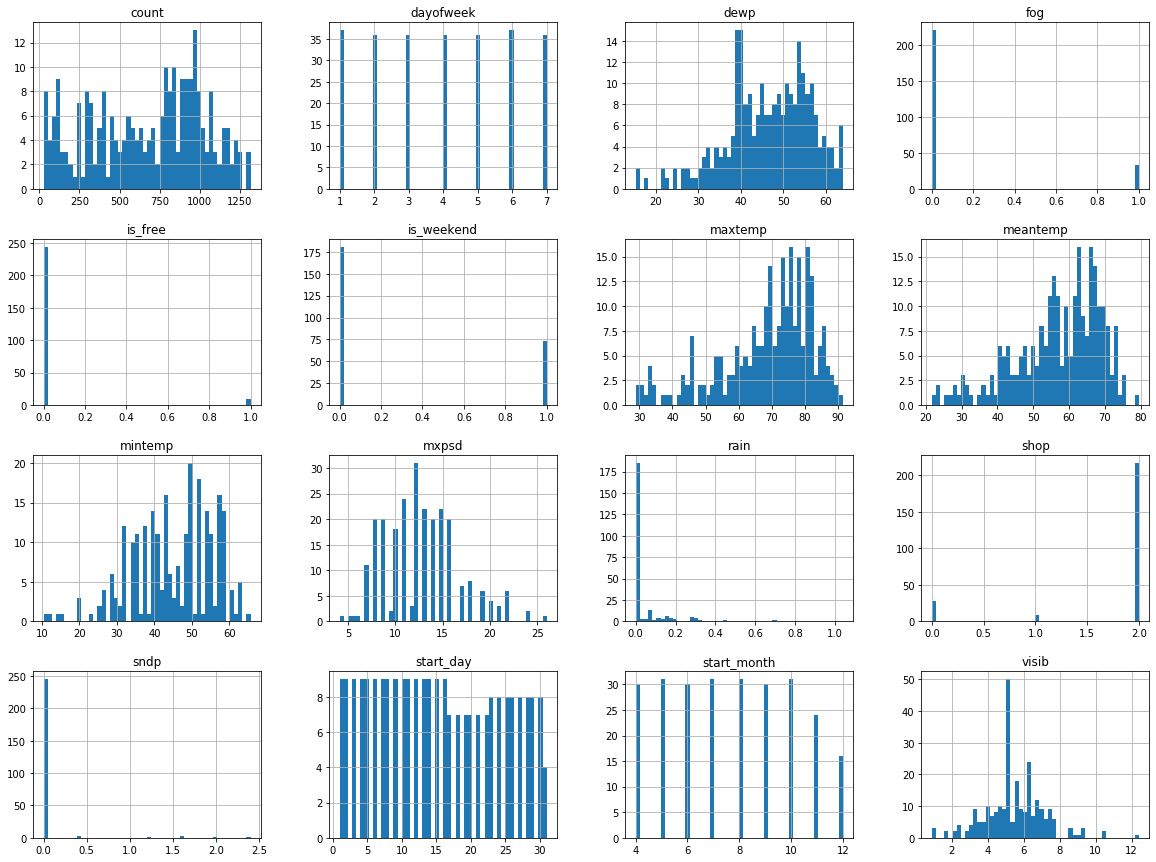

In [16]:
# To get a feel of your data, you can plot a histogram for each numerical value.
# You can see there some of the values are continuous and others seem to be categorical which we will
# further analyze in next steps.

%matplotlib inline
import matplotlib.pyplot as plt
wyp_ml_4.hist(bins=50, figsize=(20,15))
plt.show()

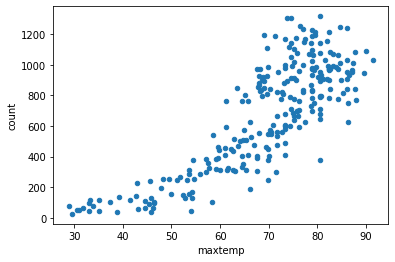

In [17]:
# Using simple scatter you can analyze dependency between features and labels

wyp_ml_4.plot(kind='scatter', x='maxtemp', y='count')

### Creating a Test Set

Let's get 20% of our dataset and save it as a test set to validate the model against when it's ready.

We could simply split the sets randomly, but a better idea might be to make sure we have good representation of data in our test set. Random sampling should be fine as long as the dataset is large enough, in this case the dataset is very small and thus we need to help with the split a little. This is called stratified sampling. The dataset is divided into homogeneous groups called strata, the goal is so that the right number of instances is sampled from each stratum for our test set to be good representation of the overall data. More here: https://medium.com/@411.codebrain/train-test-split-vs-stratifiedshufflesplit-374c3dbdcc36

Before running any ML models, we can predict that rain levels is significant factor for bike rentals numbers. This may not be the most relevant factor, but for that one, the distribution in the overall data is very skewed which means in a small dataset, its meaning might be easily lost.

The level of rain is continuous numerical attribute we need to create some categories for.

Looking at the rain histogram, we can say having 4 categories should be enough. Each category should be large enough to include good number of instances.

In [18]:
wyp_ml_4.rain.describe()

count    254.000000
mean       0.069528
std        0.160288
min        0.000000
25%        0.000000
50%        0.000000
75%        0.057500
max        1.040000
Name: rain, dtype: float64

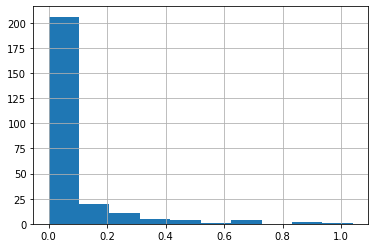

In [19]:
wyp_ml_4.rain.hist()

We will have following categories:
```
1- 0
2- 0   >= 0.3
3- 0.3 >= 0.6
4- 0.6 >=
```

In [20]:
wyp_ml_4['rain_cat'] = pd.cut(wyp_ml_4.rain, bins = [-1.0, 0.0, 0.3, 0.6, np.inf], labels = [1, 2, 3, 4])

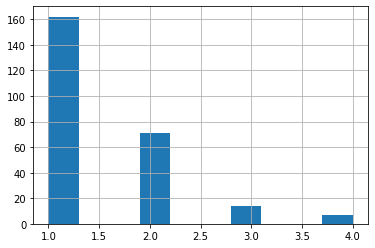

In [21]:
wyp_ml_4.rain_cat.hist()

We will use Scikit-Learn’s StratifiedShuffleSplit class to do stratified sampling based on the rain levels category:

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(wyp_ml_4, wyp_ml_4.rain_cat):
    strat_train_set = wyp_ml_4.loc[train_index]
    strat_test_set = wyp_ml_4.loc[test_index]

Let's see how many observations are there per rain levels category:

In [23]:
strat_test_set["rain_cat"].value_counts() / len(strat_test_set)

1    0.647059
2    0.274510
3    0.058824
4    0.019608
Name: rain_cat, dtype: float64

Now, this doesn't look too good, we have underrepresentation of two last categories. This is due to the fact, there is simply not enough data with observations that fits them. We need to change the categories:

```
1- 0
2- 0   >= 0.2
3- 0.2 >=
```

In [24]:
wyp_ml_4['rain_cat'] = pd.cut(wyp_ml_4.rain, bins = [-1.0, 0.0, 0.2, np.inf], labels = [1, 2, 3])

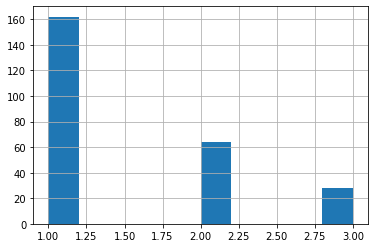

In [25]:
wyp_ml_4.rain_cat.hist()

In [26]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(wyp_ml_4, wyp_ml_4.rain_cat):
    strat_train_set = wyp_ml_4.loc[train_index]
    strat_test_set = wyp_ml_4.loc[test_index]

In [27]:
strat_test_set["rain_cat"].value_counts() / len(strat_test_set)

1    0.627451
2    0.254902
3    0.117647
Name: rain_cat, dtype: float64

It's not perfect, but quite better then it was before.

Now we can remove the rain_cat attribute to have our set in its original form

In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("rain_cat", axis=1, inplace=True)

At this point you may want to run few more visualizations on your data. Let's check how attributes correlate to each other, but first reminder of Pearson Correlation.

![Example](./data/mlst_0214.png)

In [29]:
corr_matrix = wyp_ml_4.corr()

In [30]:
corr_matrix["meantemp"].sort_values(ascending=False)

meantemp       1.000000
maxtemp        0.964671
mintemp        0.902130
dewp           0.886608
count          0.790208
visib          0.353246
rain           0.020891
start_day      0.012111
dayofweek      0.009245
shop           0.008315
mxpsd         -0.009195
is_weekend    -0.041155
is_free       -0.043203
fog           -0.149057
sndp          -0.394396
start_month   -0.532465
Name: meantemp, dtype: float64

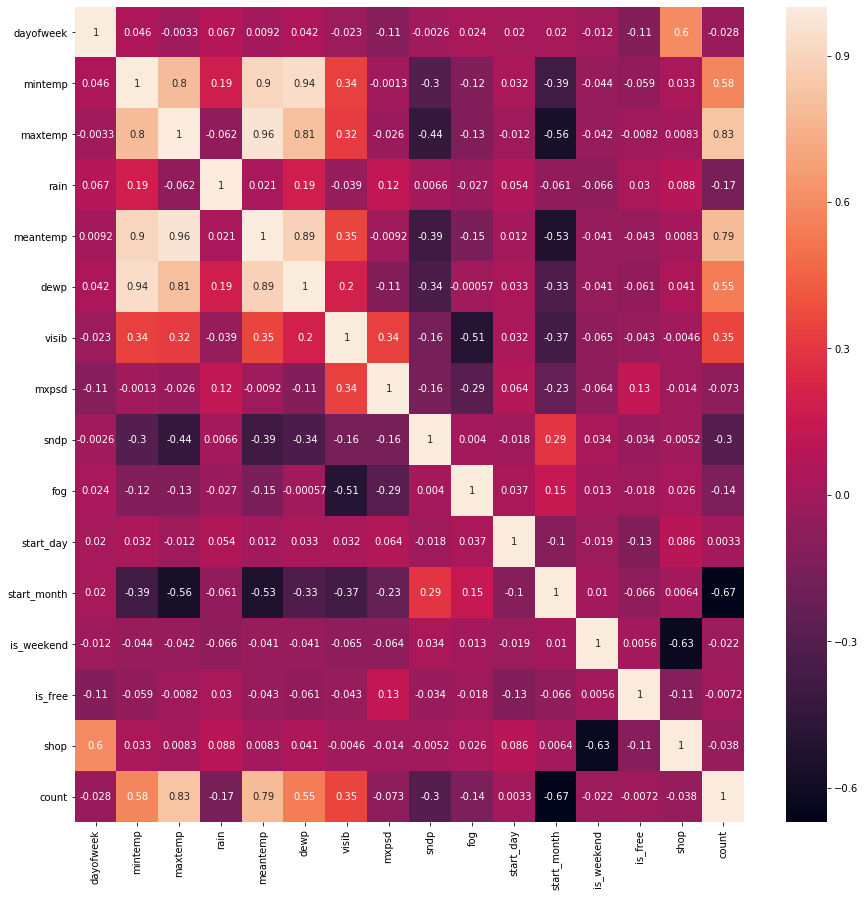

In [31]:
import seaborn as sns

plt.figure(figsize = (15, 15))
sns.heatmap(corr_matrix, annot = True)

You should further examine most promising correlations. This step, in general, is used to find out oddities in your data. Sometimes values may be capped for instance and plotting correlation scatter will reveal this. 

Other case could involve attributes with tail-heavy distribution for which you may want to transform them using their logharithm instead for instance. 

In our case let's move on. 

At some point having dedicated meeting about visualizations and quirks they can reveal could be good idea, though.

### Data Preparation for ML Algorithms

Next step is to create functions to transform the data in a way that is best suited for ML algorithms. We will start with dividing the train set to predictors and labels.

In [32]:
bikes = strat_train_set.drop("count", axis=1)
bikes_labels = strat_train_set["count"].copy()

Let's have a look at the code below and we will describe what it does once it is ran

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ['dayofweek', 'fog', 'start_day', 'start_month', 'is_weekend', 'is_free', 'shop']
num_attribs = ['mintemp', 'maxtemp', 'rain', 'meantemp', 'dewp', 'visib', 'mxpsd', 'sndp']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

First of all, we need to know which attributes are numerical and which are categorical. 

Then we may want to apply transformations on each of them separately or on all attributes altogether.

In our case, num_pipeline includes transformations that will be applied on numerical attributes only. It will look for missing values and replace them with the median for the given feature. Then it will standardise all numerical attributes.

*** What do you think should be the approach here, should be standardise, normalize (min-max scaling) values or maybe a mix of both?

We have a single transformation to be applied on categorical attributes, it is one hot encoder.

In [34]:
bikes_prepared = full_pipeline.fit_transform(bikes)

*** Remember, it is important to fir scalers to the train data only, not the full dataset or the test dataset. This is especially important so that you can easily add new data for instance. 

In [35]:
pd.DataFrame(bikes_prepared.toarray())

0         1         2         3         4         5         6   \
0    0.512797  0.091405 -0.437228  0.473900 -0.129289 -0.147510  2.373125   
1   -0.509560 -0.023310 -0.437228 -0.004715 -0.603366 -0.147510  0.579205   
2    0.293721  0.206119 -0.437228  0.104443  0.062359  0.834263  0.579205   
3    1.215667  1.331758 -0.437228  1.380751  0.869298 -0.147510 -0.189618   
4    0.147670  0.528755 -0.437228  0.331155  0.576783 -0.114401 -1.778518   
..        ...       ...       ...       ...       ...       ...       ...   
198  0.476284  0.335173 -0.437228  0.389933  0.506176  0.581286 -1.214715   
199 -1.166789 -1.600639  0.294791 -1.339801 -0.774841 -0.746843  0.809852   
200  1.297821  0.851390 -0.437228  1.145642  0.899558  1.529950 -0.189618   
201 -0.263099  0.722336 -0.437228  0.490694 -0.714320 -0.147510  1.860577   
202  0.476284  0.980444 -0.437228  0.776184  0.586869  0.897507  1.117381   

          7    8    9   ...   54   55   56   57   58   59   60   61   62   63  
0   -0.15891  0.0  0.0  ...  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  
1   -0.15891  0.0  1.0  ...  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  
2   -0.15891  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  
3   -0.15891  0.0  1.0  ...  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  
4   -0.15891  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  
..       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
198 -0.15891  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  
199 -0.15891  0.0  0.0  ...  0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  
200 -0.15891  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  
201 -0.15891  0.0  1.0  ...  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  
202 -0.15891  1.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  

[203 rows x 64 columns]

### Choosing and Training a Model!

So now it is the time for what we all waited for ... let's get on with the most interesting and spectacular part - training a Machine Learning Model!!!

We will start with Linear Regression.

In [58]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(bikes_prepared, bikes_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/LwHfaQM6AzEu44CqJO/giphy.gif">')

Well ... that wasn't spectacular at all.

But that indeed is what we need to train a model. Anyway, let's have a look at how it went.

In [60]:
from sklearn.metrics import mean_squared_error
bikes_predictions = lin_reg.predict(bikes_prepared)
lin_mse = mean_squared_error(bikes_labels, bikes_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

115.60386770995305

Not too bad - compared to our benchmark which was 340! But we can do better I'm sure. Decision Trees next

In [61]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(bikes_prepared, bikes_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [62]:
bikes_predictions = tree_reg.predict(bikes_prepared)
tree_mse = mean_squared_error(bikes_labels, bikes_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Hm ... Is this for real? No error at all? Do we have a perfect model? Well ... no. This is an example of overfitting the data, badly. How to verify this? Until you know which model to choose, you shouldn't touch the test data. Instead, you should use part of the training set for training and part for model validation.

One way to do it is by using the Scikit-Learn's cross-validation feature. It randomly splits the dataset into a number of distinct subsets called folds, then it trains and evaluates the Decision Trees model as many times as many folds there are using different fold for evaluation every time and training on the remaining 9 folds. We have an array of 10 evaluation scores as the result.

In [63]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, bikes_prepared, bikes_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [64]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [65]:
display_scores(tree_rmse_scores)

Scores: [152.81111902 194.86344425 215.67888388 207.39431043 222.72011584
 252.72277301 144.41502692 186.57652585 178.80338364 260.47754222]
Mean: 201.64631250644246
Standard deviation: 36.33067227278156


Aaaand it doesn't look that good any more. In fact it seems to perform a lot worse than simple linear regression model. 

With cross-validation you also get standard deviation - a measure of how precise the estimate is. So the Decision Tree has a score of 183 +/- 37.

Let's check the score the same way for Linear Regression, though

In [66]:
lin_scores = cross_val_score(lin_reg, bikes_prepared, bikes_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [177.41263352 213.47693386 187.97824888 210.84798686 119.16894843
 136.33754659 162.12862957 205.87500804 151.77567171 151.22675339]
Mean: 171.62283608619964
Standard deviation: 31.08234641306093


Indeed, it seems that the Decision Tree is overfitting too hard and as a result it performs worse then a Linear Regression model. 

Let's try Random Forest now.

In [67]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(bikes_prepared, bikes_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [68]:
bikes_predictions = forest_reg.predict(bikes_prepared)
forest_mse = mean_squared_error(bikes_labels, bikes_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

53.94364194148677

In [69]:
forest_scores = cross_val_score(forest_reg, bikes_prepared, bikes_labels,
                             scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [114.62681538 145.66357578 190.37699183 150.48171748 146.78708037
 160.13510018  97.99394992 163.49116848 124.51076739 129.86258768]
Mean: 142.3929754492291
Standard deviation: 25.252390768966265


Now, this is even better. Bear in mind that the score on the training set is still significantly lower than on the validation sets. This means the model is still overfitting the training set.

Let's try two last models, XGBoost and then Support Vector Regression

In [70]:
import xgboost as xgb

xgboost_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgboost_reg.fit(bikes_prepared, bikes_labels)

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [71]:
bikes_predictions = xgboost_reg.predict(bikes_prepared)
xgboost_mse = mean_squared_error(bikes_labels, bikes_predictions)
xgboost_rmse = np.sqrt(xgboost_mse)
xgboost_rmse

53.82147198448323

In [72]:
xgboost_scores = cross_val_score(xgboost_reg, bikes_prepared, bikes_labels,
                             scoring="neg_mean_squared_error", cv=10)

xgboost_rmse_scores = np.sqrt(-xgboost_scores)
display_scores(xgboost_rmse_scores)

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

Scores: [116.85793344 165.76701912 186.34090543 155.2390727  140.67018814
 150.18450279 117.42742985 182.53252766 121.94471411 133.49589891]
Mean: 147.0460192153819
Standard deviation: 24.235812894075753


/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


SVM

In [73]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf")
svm_reg.fit(bikes_prepared, bikes_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [74]:
bikes_predictions = svm_reg.predict(bikes_prepared)
svm_mse = mean_squared_error(bikes_labels, bikes_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

358.72819422984963

In [75]:
svm_scores = cross_val_score(svm_reg, bikes_prepared, bikes_labels,
                             scoring="neg_mean_squared_error", cv=10)

svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [368.81258428 422.88324594 343.86310311 420.91964345 281.69095228
 371.12758729 351.50726932 338.2536846  369.45853369 311.19176886]
Mean: 357.970837281482
Standard deviation: 41.515367991915085


In [76]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf")
svm_reg.fit(bikes_prepared, bikes_labels)

bikes_predictions = svm_reg.predict(bikes_prepared)
svm_mse = mean_squared_error(bikes_labels, bikes_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

svm_scores = cross_val_score(svm_reg, bikes_prepared, bikes_labels,
                             scoring="neg_mean_squared_error", cv=10)

svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [368.81258428 422.88324594 343.86310311 420.91964345 281.69095228
 371.12758729 351.50726932 338.2536846  369.45853369 311.19176886]
Mean: 357.970837281482
Standard deviation: 41.515367991915085


### Fine tunning the models

#### Linear Regression

In [77]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = [
    {'fit_intercept':[True], 'normalize':[True,False], 'copy_X':[True,False]},
    {'fit_intercept':[False], 'copy_X':[True,False]},
]
    
linear_reg = LinearRegression()
grid_search_lr = GridSearchCV(linear_reg, param_grid_lr, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search_lr.fit(bikes_prepared, bikes_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'copy_X': [True, False], 'fit_intercept': [True],
                          'normalize': [True, False]},
                         {'copy_X': [True, False], 'fit_intercept': [False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [78]:
grid_search_lr.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [79]:
cvres_lr = grid_search_lr.cv_results_

for mean_score, params in zip(cvres_lr["mean_test_score"], cvres_lr["params"]):
    print(np.sqrt(-mean_score), params)

174.41476992153133 {'copy_X': True, 'fit_intercept': True, 'normalize': True}
174.41476464110505 {'copy_X': True, 'fit_intercept': True, 'normalize': False}
174.41476992153133 {'copy_X': False, 'fit_intercept': True, 'normalize': True}
174.41476464110505 {'copy_X': False, 'fit_intercept': True, 'normalize': False}
174.41477076569478 {'copy_X': True, 'fit_intercept': False}
174.41477076569478 {'copy_X': False, 'fit_intercept': False}


#### Random Forest

In [80]:
param_grid_rf = [
    {'n_estimators': [3, 10, 100, 1000], 'max_features': [4, 16, 64], 'n_jobs': [7]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 100, 1000], 'max_features': [4, 16, 64], 'n_jobs': [7]},
  ]

forest_reg = RandomForestRegressor()

grid_search_rf = GridSearchCV(forest_reg, param_grid_rf, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_rf.fit(bikes_prepared, bikes_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [81]:
grid_search_rf.best_params_

{'max_features': 64, 'n_estimators': 1000, 'n_jobs': 7}

In [82]:
cvres_rf = grid_search_rf.cv_results_

for mean_score, params in zip(cvres_rf["mean_test_score"], cvres_rf["params"]):
    print(np.sqrt(-mean_score), params)

242.74880706881618 {'max_features': 4, 'n_estimators': 3, 'n_jobs': 7}
202.65143264644968 {'max_features': 4, 'n_estimators': 10, 'n_jobs': 7}
187.94921328733798 {'max_features': 4, 'n_estimators': 100, 'n_jobs': 7}
184.26577571276448 {'max_features': 4, 'n_estimators': 1000, 'n_jobs': 7}
196.71709378305147 {'max_features': 16, 'n_estimators': 3, 'n_jobs': 7}
174.79555322384283 {'max_features': 16, 'n_estimators': 10, 'n_jobs': 7}
158.39304527996478 {'max_features': 16, 'n_estimators': 100, 'n_jobs': 7}
157.485066980016 {'max_features': 16, 'n_estimators': 1000, 'n_jobs': 7}
169.22067362504444 {'max_features': 64, 'n_estimators': 3, 'n_jobs': 7}
161.29601741942005 {'max_features': 64, 'n_estimators': 10, 'n_jobs': 7}
151.32485544806593 {'max_features': 64, 'n_estimators': 100, 'n_jobs': 7}
149.92141798347552 {'max_features': 64, 'n_estimators': 1000, 'n_jobs': 7}
221.08762530347695 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3, 'n_jobs': 7}
189.91403215601554 {'bootstrap': 

#### XGBoost

In [83]:
param_grid_xgb = [
    {'objective': ['reg:squarederror', 'reg:logistic'], 'colsample_bytree': [0.3, 0.6, 1],
     'eta': [0.01, 0.3, 0.5], 'max_depth': [3, 6, 18], 'alpha': [0, 10, 100], 'n_estimators': [100, 1000],
     'subsample': [0.8, 0.9, 1], 'gamma': [0, 1, 5], 'n_jobs': [7]},
  ]

xgboost_reg = xgb.XGBRegressor()

grid_search_xgb = GridSearchCV(xgboost_reg, param_grid_xgb, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_xgb.fit(bikes_prepared, bikes_labels)

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: [14:00:16] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /home/mpastecki/ml/.env/xgboost/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x24) [0x7f469cd6acb4]
  [bt] (1) /home/mpastecki/ml/.env/xgboost/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: [14:00:33] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /home/mpastecki/ml/.env/xgboost/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x24) [0x7f469cd6acb4]
  [bt] (1) /home/mpastecki/ml/.env/xgboost/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LogisticRegression>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x805) [0x7f469cf75405]
  [bt] (2) /home/mpastecki/ml/.env/xgboost/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x345) [0x7f469ce04505]
  [bt] (3) /home/mpastecki/ml/.env/xgboost/libxgboost.so(XGBooste

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: [14:00:43] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /home/mpastecki/ml/.env/xgboost/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x24) [0x7f469cd6acb4]
  [bt] (1) /home/mpastecki/ml/.env/xgboost/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LogisticRegression>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x805) [0x7f469cf75405]
 

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: [14:02:47] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /h

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: [14:03:34] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /h

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: [14:07:15] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /h

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for t

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for t

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: [14:16:08] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /home/mpastecki/ml/.env/xgboost/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x24) [0x7f469cd6acb4]
  [bt] (1) /home/mpastecki/ml/.env/xgboost/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: [14:17:00] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /h

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: [14:17:48] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /home/mpastecki/ml/.env/xgboost/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x24) [0x7f469cd6acb4]
  [bt] (1) /home/mpastecki/ml/.env/xgboost/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LogisticRegression>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x805) [0x7f469cf75405]
  [bt] (2) /home/mpastecki/ml/.env/xgboost/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x345) [0x7f469ce04505]
  [bt] (3) /home/mpastecki/ml/.env/xgboost/libxgboost.so(XGBooste

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mpastecki/ml/.env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0, 10, 100],
                          'colsample_bytree': [0.3, 0.6, 1],
                          'eta': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5],
                          'max_depth': [3, 6, 18], 'n_estimators': [100, 1000],
                    

In [87]:
grid_search_xgb.best_params_

{'alpha': 0,
 'colsample_bytree': 0.6,
 'eta': 0.01,
 'gamma': 0,
 'max_depth': 6,
 'n_estimators': 100,
 'n_jobs': 7,
 'objective': 'reg:squarederror',
 'subsample': 1}

In [88]:
cvres_xgb = grid_search_xgb.cv_results_

for mean_score, params in zip(cvres_xgb["mean_test_score"], cvres_xgb["params"]):
    print(np.sqrt(-mean_score), params)

163.59650068981065 {'alpha': 0, 'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 7, 'objective': 'reg:squarederror', 'subsample': 0.8}
165.22753484680916 {'alpha': 0, 'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 7, 'objective': 'reg:squarederror', 'subsample': 0.9}
162.20588224472144 {'alpha': 0, 'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 7, 'objective': 'reg:squarederror', 'subsample': 1}
nan {'alpha': 0, 'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 7, 'objective': 'reg:logistic', 'subsample': 0.8}
nan {'alpha': 0, 'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 7, 'objective': 'reg:logistic', 'subsample': 0.9}
nan {'alpha': 0, 'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 7, 'objecti

nan {'alpha': 10, 'colsample_bytree': 0.3, 'eta': 0.5, 'gamma': 0, 'max_depth': 18, 'n_estimators': 100, 'n_jobs': 7, 'objective': 'reg:logistic', 'subsample': 0.9}
nan {'alpha': 10, 'colsample_bytree': 0.3, 'eta': 0.5, 'gamma': 0, 'max_depth': 18, 'n_estimators': 100, 'n_jobs': 7, 'objective': 'reg:logistic', 'subsample': 1}
169.21324454421278 {'alpha': 10, 'colsample_bytree': 0.3, 'eta': 0.5, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_jobs': 7, 'objective': 'reg:squarederror', 'subsample': 0.8}
170.85662866906787 {'alpha': 10, 'colsample_bytree': 0.3, 'eta': 0.5, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_jobs': 7, 'objective': 'reg:squarederror', 'subsample': 0.9}
164.78054406095944 {'alpha': 10, 'colsample_bytree': 0.3, 'eta': 0.5, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_jobs': 7, 'objective': 'reg:squarederror', 'subsample': 1}
nan {'alpha': 10, 'colsample_bytree': 0.3, 'eta': 0.5, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_jobs': 7, 

161.24397524386063 {'alpha': 100, 'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_jobs': 7, 'objective': 'reg:squarederror', 'subsample': 0.8}
161.23552268969658 {'alpha': 100, 'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_jobs': 7, 'objective': 'reg:squarederror', 'subsample': 0.9}
159.9204757064386 {'alpha': 100, 'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_jobs': 7, 'objective': 'reg:squarederror', 'subsample': 1}
nan {'alpha': 100, 'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_jobs': 7, 'objective': 'reg:logistic', 'subsample': 0.8}
nan {'alpha': 100, 'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_jobs': 7, 'objective': 'reg:logistic', 'subsample': 0.9}
nan {'alpha': 100, 'colsample_bytree': 0.6, 'eta': 0.3, 'gamma': 0, 'max_depth': 18, 'n_estimators': 1000, 'n_j

#### Support Vector Machine

In [89]:
param_grid_svm = [
    {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
  ]

svm_reg = SVR(kernel="rbf")

grid_search_svm = GridSearchCV(svm_reg, param_grid_svm, cv=20,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_svm.fit(bikes_prepared, bikes_labels)

GridSearchCV(cv=20, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10],
                          'gamma': [0.001, 0.01, 0.1, 1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [90]:
grid_search_svm.best_params_

{'C': 10, 'gamma': 0.1}

In [91]:
cvres_svm = grid_search_svm.cv_results_

for mean_score, params in zip(cvres_svm["mean_test_score"], cvres_svm["params"]):
    print(np.sqrt(-mean_score), params)

369.7321729666606 {'C': 0.001, 'gamma': 0.001}
369.72807056586606 {'C': 0.001, 'gamma': 0.01}
369.72612776200765 {'C': 0.001, 'gamma': 0.1}
369.73278935051064 {'C': 0.001, 'gamma': 1}
369.7264742858378 {'C': 0.01, 'gamma': 0.001}
369.6854556912414 {'C': 0.01, 'gamma': 0.01}
369.66603303597583 {'C': 0.01, 'gamma': 0.1}
369.73263802180367 {'C': 0.01, 'gamma': 1}
369.669497677779 {'C': 0.1, 'gamma': 0.001}
369.25985376486045 {'C': 0.1, 'gamma': 0.01}
369.06616679486086 {'C': 0.1, 'gamma': 0.1}
369.7311247823234 {'C': 0.1, 'gamma': 1}
369.1007533604615 {'C': 1, 'gamma': 0.001}
365.2533241568627 {'C': 1, 'gamma': 0.01}
363.6530159499394 {'C': 1, 'gamma': 0.1}
369.71459329828673 {'C': 1, 'gamma': 1}
363.7427374526259 {'C': 10, 'gamma': 0.001}
319.400094667626 {'C': 10, 'gamma': 0.01}
300.38207731137726 {'C': 10, 'gamma': 0.1}
369.48646752861214 {'C': 10, 'gamma': 1}


### Evaluating on the Test Set using Linear Regression and Random Forest as an examples

In [92]:
final_model = grid_search_lr.best_estimator_

X_test = strat_test_set.drop("count", axis=1)
y_test = strat_test_set["count"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [93]:
final_rmse

163.4928896608128

In [94]:
final_model = grid_search_rf.best_estimator_

X_test = strat_test_set.drop("count", axis=1)
y_test = strat_test_set["count"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [95]:
final_rmse

151.0897085543526

In [96]:
final_model = grid_search_xgb.best_estimator_

X_test = strat_test_set.drop("count", axis=1)
y_test = strat_test_set["count"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [97]:
final_rmse

164.03802911856744

In [98]:
final_model = grid_search_svm.best_estimator_

X_test = strat_test_set.drop("count", axis=1)
y_test = strat_test_set["count"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [99]:
final_rmse

276.2101858496669

### Summary

We have defined our goal, prepared the dataset with data that is significant to predict what we're looking for. Then, we have transformed the data so that it is in a form that is readable by Machine Learning algorithms. 

Eventually, we have trained a few different models, fine tunned them and evaluated their performance.